<a href="https://colab.research.google.com/github/matteograsso98/energy_forecasting/blob/main/random_forest_pv_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predizione energetica impianto fotovoltaico

Two data files are provided

1. prod.csv contains the energy production of a photovoltaic plant, divided in 15-minutes time intervals  

2. meteo.csv provides whether conditions at the photovoltaic plant position, by hour, for the same years of the previous data set.

Create a model able to predict the energy production, by hour, as a function of whether variables.  

1. Features exploration - clean the data/find outliers/patterns between variables/ main features to preidct energy production
2. Train a model and compute the MAE over the last 6 months

Evaluation chriteria
- clarity
- algorithm performance
- identication of patterns in the dataset
- outlook/conclusions

Time available = 4h

------------

## Plan (schematically)

###  1. data preprocessing
Clean the data sets, find outliers, process the data sets

### 2. Feature Selection
In this case we don't have too many features, thus we can keep them and use them all.

### 3. Modeling (selection & training)
- Random forest is robust to outliers and noisy data
 (aggregate predictions from multiple decision trees, which helps to reduce the impact of individual noisy observations)
- Random forests can capture complex non-linear patterns
- Feature importance: Random forests provide a measure of feature importance
- Scalability: Random forests can handle large datasets with a high number of features efficiently (parallelization of the training process; suitable for big data scenarios)



In [ ]:
#import relevant libraries
import pandas as pd #managing the data set
import numpy as np #calculations
import matplotlib.pyplot as plt #make plots
import matplotlib.dates as mdates
import seaborn as sns #make feature plots easily

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Grid Search implementation
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Load / process  the data set, visualize the features

## prod.csv

In [ ]:
df_meteo = pd.read_csv('meteo.csv')
df_meteo.info() #more information about the features and data type
df_meteo = df_meteo.dropna() #delete the NaN

df_meteo['timestamp_utc'] = df_meteo.timestamp_utc.apply(pd.to_datetime) #make sure date is in the right format

df_meteo = df_meteo.drop(['id', 'Unnamed: 0'], axis=1, errors='ignore') #drop id / unnamed cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            14000 non-null  int64  
 1   id                    14000 non-null  int64  
 2   timestamp_utc         14000 non-null  object 
 3   temperature_2m_C      13437 non-null  float64
 4   diffuse_rad_w         14000 non-null  float64
 5   direct_rad_w          14000 non-null  float64
 6   low_cloud_cover_p     14000 non-null  float64
 7   medium_cloud_cover_p  14000 non-null  float64
 8   high_cloud_cover_p    14000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 984.5+ KB


In [ ]:
for i in df_meteo:
  print(f'{i}' + '     ', f'{min(df_meteo[i]):.2f}', f'{max(df_meteo[i]):.2f}')


timestamp_utc      .2f .2f
temperature_2m_C      -4.58 41.33
diffuse_rad_w      0.00 357.00
direct_rad_w      0.00 881.43
low_cloud_cover_p      0.00 101.00
medium_cloud_cover_p      0.00 101.00
high_cloud_cover_p      0.00 101.00


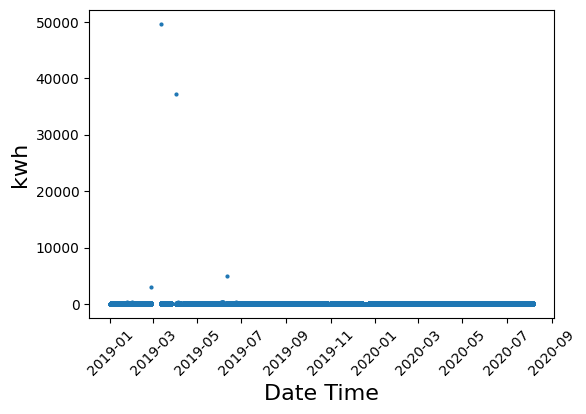

In [ ]:
#same for energy production data set
df_prod = pd.read_csv('prod.csv')
df_prod = df_prod.dropna()
df_prod["start_date_utc"] = pd.to_datetime(df_prod["start_date_utc"])
df_prod["end_date_utc"] = pd.to_datetime(df_prod["end_date_utc"])
df_prod = df_prod.drop(['id', 'Unnamed: 0'], axis=1, errors='ignore') #drop id / unnamed cols

#we can plot the target variable kwh vs time
plt.figure(figsize=(6,4))
plt.plot(df_prod.start_date_utc, df_prod.kwh, 'o', markersize=2)
plt.xlabel("Date Time", fontsize=16)
plt.ylabel('kwh', fontsize=16)
plt.xticks(rotation=45)
plt.show();

We immediately notice some weird high values in kwh. Notice that they are not present in 2020 (around the same period of the year). They likely arise because something broke in the photovoltaic plants/because of tough wether conditions.
For example, one may explore the meteo data set and see if on those dates there were particular wether conditions.
Also, if we look at dates sorrounding those points, we don't find similar values!  

Let's get rid of those values.

In general for outliers one can use IQR (Inter Quartile Range), which is the most commonly used and most trusted approach used in the research field.
Essentially, we first compute the 1st and 3rd quartile, then the 0.5 scale-up of IQR (new_IQR = IQR + 0.5*IQR) is taken to consider all the data between 2.7 standard deviations in the Gaussian Distribution.


In [ ]:
Q1 = df_prod['kwh'].quantile(0.25)
Q3 = df_prod['kwh'].quantile(0.75)
print('Q3', Q3)
print('1.5*IQR:', (Q3-Q1)*1.5)
print('number of zeros in prod.csv:', (df_prod['kwh'] == 0).sum())

Q3 61.14625706997158
1.5*IQR: 91.71938560495738
number of zeros in prod.csv: 27442


In [ ]:
print("Old Shape: ", df_prod.shape)

# IQR
# Calculate the upper and lower limits
Q1 = df_prod['kwh'].quantile(0.25)
Q3 = df_prod['kwh'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR #lower bound and 0.5 scale-up IQR to take points in 2.5 sigma of the gauss.dist.
upper = Q3 + 1.5*IQR #upper bound ""

# Filter out outliers
df_prod = df_prod[(df_prod['kwh'] > lower) & (df_prod['kwh'] < 1000)] #I've changed the upper bound to delete only prod > 1000 kwh

# Print the new shape of the DataFrame
print("New Shape: ", df_prod.shape)

Old Shape:  (53359, 3)
New Shape:  (53355, 3)


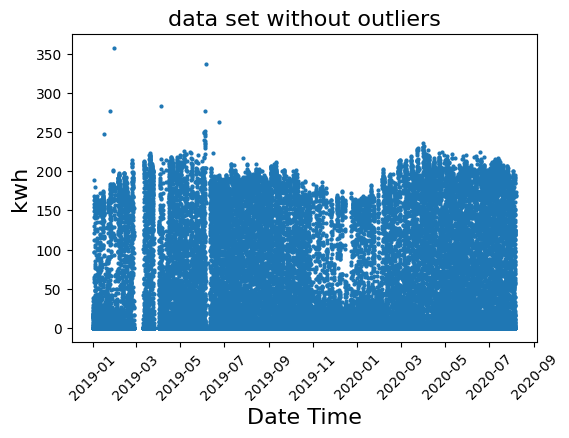

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(df_prod.start_date_utc, df_prod.kwh, 'o', markersize=2)
plt.xlabel("Date Time", fontsize=16)
plt.ylabel('kwh', fontsize=16)
plt.title('data set without outliers', fontsize=16)
plt.xticks(rotation=45)
plt.show();

## meteo.csv
### Remarks

- After exploring meteo.csv, my intuition is:
I expect direct radiation, and low clouds cover percentage to be the most impactful features on this analysis.
Tricky part: I know from physics that (although people are often suspicious about it) increasing the temperature decreases the photovoltaic panel efficiency.


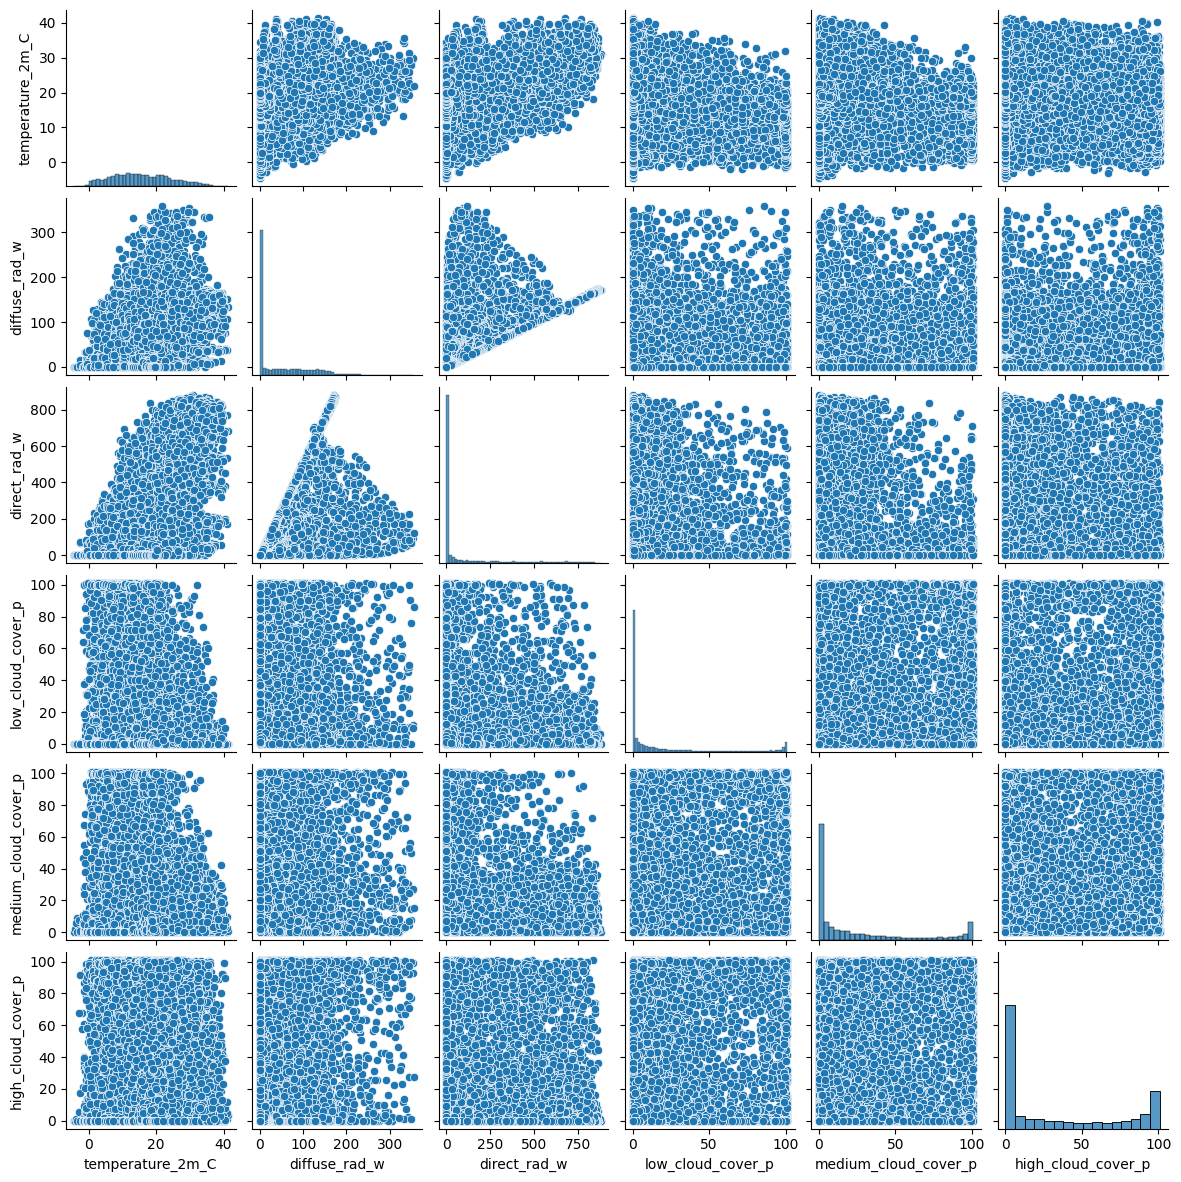

In [ ]:
sns.pairplot(df_meteo, height=2) #feature visualization

### Some more remarks

- Some patterns I noticed:
  - Temperature and direct/diffuse radiation are not independent, as expected.
  - Direct and diffuse radiation are clearly not independent. The plot shows a straight cut-off: not any pair (direct_rad, diffuse_rad) is allowed! (this also comes from physics: from https://www.sciencedirect.com/science/article/abs/pii/S0022407312004141 --> "[...] In this work, it is found that the solution of diffuse radiation is a special case of the solution for direct radiation. No extra effort is needed to find out the solution of diffuse radiation [...] )

- Data sets have different lenghts (one takes the data hourly, the other one each 15 minutes).

 **The solution might be to either forward fill or interpolate wether conditions each 15 minutes, and then merge the data sets**
 Essentially:
 - if wether conditions remain stable over one hour-time-interval, then forward fill (copies the last known value to fill missing data) it is a good idea
 - if not, interpolation gives better results

 I'd pick interpolation to be more accurate/able to capture short-terms variations

### Interpolation / Merging

1. We interpolate wether conditions each 15 minutes
2. We merge the data sets

Note that in prod.csv, there are some data starting at a date and ending the day before.

In [ ]:
# Interpolate weather data to 15-minute intervals using cubic interpolation
df_meteo_int = df_meteo.set_index("timestamp_utc").resample("15T").interpolate(method="cubic").reset_index()

# Merge on timestamp (or closest available timestamp)
df_merged = pd.merge_asof(df_prod.sort_values("start_date_utc"),
                          df_meteo_int.sort_values("timestamp_utc"),
                          left_on="start_date_utc",
                          right_on="timestamp_utc",
                          direction="backward")  # Assign closest past weather value

<ipython-input-9-d8619cd7c716>:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_meteo_int = df_meteo.set_index("timestamp_utc").resample("15T").interpolate(method="cubic").reset_index()


In [ ]:
#there will be some NaN for the 31/12/2018 where only prod.csv has data
df_merged = df_merged.dropna() #eliminate the NaN
df_merged.head(4)

,start_date_utc,end_date_utc,kwh,timestamp_utc,temperature_2m_C,diffuse_rad_w,direct_rad_w,low_cloud_cover_p,medium_cloud_cover_p,high_cloud_cover_p
5,2019-01-01 00:00:00,2019-01-01 00:15:00,0.0,2019-01-01 00:00:00,3.885211,0.000000,0.000000,53.898312,6.178847,0.000000
6,2019-01-01 00:15:00,2019-01-01 00:30:00,0.0,2019-01-01 00:15:00,3.773741,-0.002717,-0.008799,37.802761,3.650614,-0.039178
7,2019-01-01 00:30:00,2019-01-01 00:45:00,0.0,2019-01-01 00:30:00,3.755238,-0.003105,-0.010056,26.329667,2.366657,-0.044775
8,2019-01-01 00:45:00,2019-01-01 01:00:00,0.0,2019-01-01 00:45:00,3.808689,-0.001941,-0.006285,18.966816,2.069255,-0.027984


<Axes: xlabel='diffuse_rad_w', ylabel='kwh'>

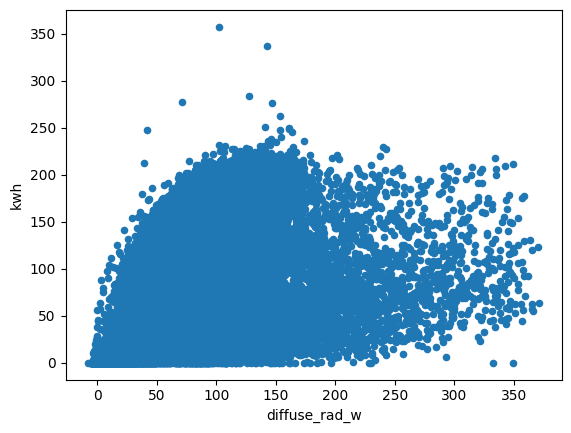

In [ ]:
df_merged.plot('diffuse_rad_w', 'kwh', kind='scatter')

# Modeling and Training

## Some model options:

- Random Forest
- Gradient Boosting (XGBoost, LightGBM)
- Train a neural networks, such as a LSTM or a Transformer because they're able to remember about past values.

## Important!!:
We are training on a data set (the merged one) with resolution equals to 15-mins
intervals. However, the assessment ask for energy production prediction HOURLY. This can be achieved afterwards. I trained the data by shuffling them because THIS YIELDS A BETTER MAE. On the other hand, in this way we're losing the time order. So, if needed, one can order the data after the training (now I don't have time bc I need to submit this notebook)

Remember that Random Forest doesn’t understand sequences (this is why I shuffled the data), but it does understand patterns.

## Random-Forest implementation
### Hyperparameter optimisation
We cannot use K-fold cross-validation but we can use **cross validation on rolling basis**. This essentially means:

1.Take a small subset of data for training

2.Forecast for the later data points

3.Check the accuracy for the forecasted data points.

4.The same forecasted data points are then included as part of the next training dataset and subsequent data points are forecasted.

### RF hyperparaemters
- n_estimators = n. of trees
- max_features: Limits the number of features to consider when splitting a node. This helps control overfitting.

By default: max_features="sqrt" [available: ["sqrt", "log2", None}]

sqrt: Selects the square root of the total features. This is a common setting to reduce overfitting and speed up the model.
log2: This option selects the base-2 logarithm of the total number of features. It provide more randomness and reduce overfitting more than the square root option.
None: If None is chosen the model uses all available features for splitting each node. This increases the model’s complexity and may cause overfitting, especially with many features.

- max_depth: Controls the maximum depth of each tree. A shallow tree may underfit while a deep tree may overfit.

By default: max_depth=None

- max_leaf_nodes: Limits the number of leaf nodes in the tree hence controlling its size and complexity.

By default: max_leaf_nodes = None
max_leaf_nodes = None means it takes an unlimited number of nodes

### On the last 6 months


In [ ]:
# Hyperparameters tuning
from sklearn.pipeline import make_pipeline

# current date
current_date = df_merged['timestamp_utc'].max()

# filter for the last 6 months of data
six_months_ago = current_date - pd.DateOffset(months=6)
df_six_months = df_merged[df_merged['timestamp_utc'] >= six_months_ago]

# define features (X) and target variable (y) for the filtered data
X_six_months = df_six_months.drop(columns=["start_date_utc", "end_date_utc", "timestamp_utc", "kwh"])  # drop non-numerical columns and the target var
y_six_months = df_six_months["kwh"]

# split into training (80%) and test (20%) sets as usual
X_train_six, X_test_six, y_train_six, y_test_six = train_test_split(X_six_months, y_six_months, \
                                                                    test_size=.2, random_state=42, shuffle = False)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 90, 100, 140],  # Sampling all values between 50 and 100
    'max_features': ["sqrt", "log2", None],
    'criterion': ['squared_error', 'friedman_mse', 'poisson']
}

# train with Random Forest
rf = RandomForestRegressor(random_state=42)

# Define time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform Grid Search with TimeSeriesSplit
grid_search = GridSearchCV(rf, param_grid, cv=tscv, refit = True,  \
                           scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train_six, y_train_six)

# Best Scores
print("Best Scores:", grid_search.best_score_)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

Mean Absolute Error (MAE): 12.08 kWh


<ipython-input-12-92fd437eff71>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x="Importance", y="Feature", palette="viridis")


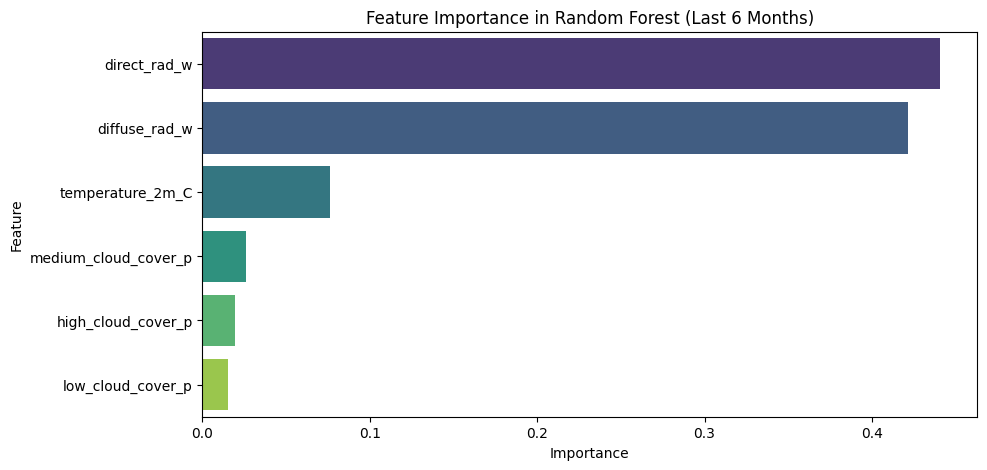

In [ ]:
rf = RandomForestRegressor(n_estimators=140, criterion = 'poisson', max_features = 'sqrt', random_state=42, n_jobs=-1)
rf.fit(X_train_six, y_train_six)

# predictions
y_pred_six = rf.predict(X_test_six)

# metrics - MAE in our case
mae = mean_absolute_error(y_test_six, y_pred_six)
print(f"Mean Absolute Error (MAE): {mae:.2f} kWh")

# Feature Importance
feature_importance = pd.DataFrame({"Feature": X_six_months.columns, "Importance": rf.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(data=feature_importance, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance in Random Forest (Last 6 Months)")
plt.show();

As expected, the most important features are the direct and diffuse radiations, and the temperature. Although I thought that low cloud coverage was more important than medium/high cover, it seems like they play a similar role.

### Exactly the same but on the whole period of time
Just copied-pasted the code above but we don't need to filter it this time

Mean Absolute Error (MAE): 12.53 kWh


<ipython-input-14-ee489e77aa74>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x="Importance", y="Feature", palette="viridis")


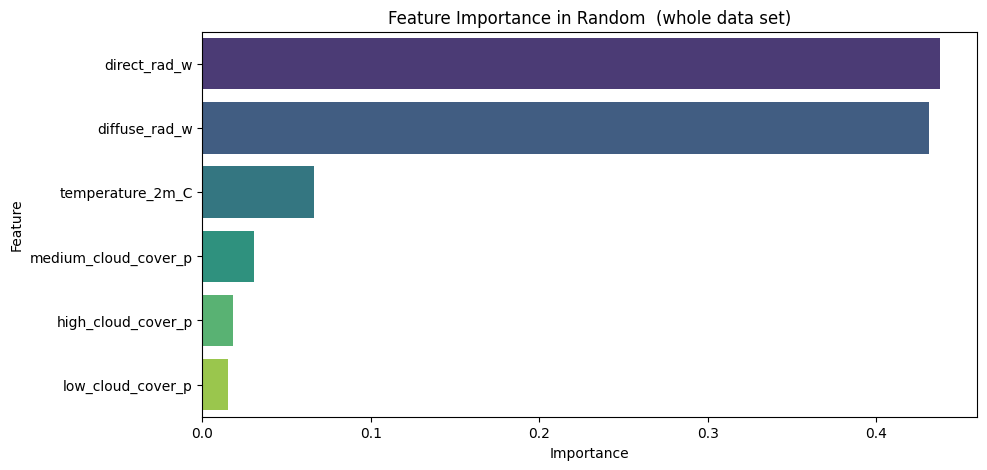

In [ ]:
df = df_merged.copy()
X = df.drop(columns=["start_date_utc", "end_date_utc", "timestamp_utc", "kwh"])  # Drop non-numeric columns
y = df["kwh"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = False) #~10 months used for training and 2 for test

# training with Random Forest
rf = RandomForestRegressor(n_estimators=140, criterion = 'poisson', max_features = 'sqrt', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# predictions
y_pred = rf.predict(X_test)

# metrics - MAE
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} kWh")

# feature Importance
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": rf.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(data=feature_importance, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance in Random  (whole data set)")
plt.show();


## Predictions vs observations

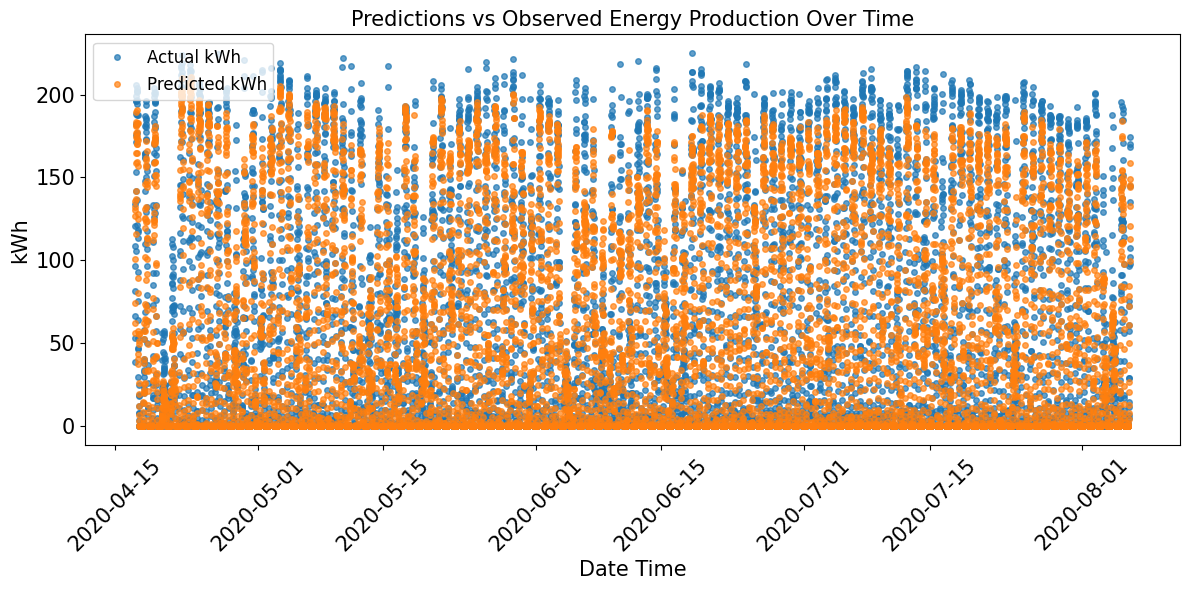

In [ ]:
# Add the predictions (y_pred) to the test set DataFrame for plotting
df_test = X_test.copy()
df_test['Actual kWh'] = y_test
df_test['Predicted kWh'] = y_pred
df_test['timestamp_utc'] = df_merged.loc[df_test.index, 'timestamp_utc']  # Use the original timestamps

# Plot predictions vs actual values over time
plt.figure(figsize=(12, 6))
plt.plot(df_test['timestamp_utc'], df_test['Actual kWh'], 'o', label='Actual kWh', alpha=0.7, markersize=4)
plt.plot(df_test['timestamp_utc'], df_test['Predicted kWh'], 'o', label='Predicted kWh', alpha=0.7, markersize= 4)
#customisation
plt.xlabel('Date Time', fontsize=15)
plt.ylabel('kWh', fontsize=15)
plt.title('Predictions vs Observed Energy Production Over Time', fontsize = 15)
plt.legend(fontsize=12, loc = 'upper left')
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show();

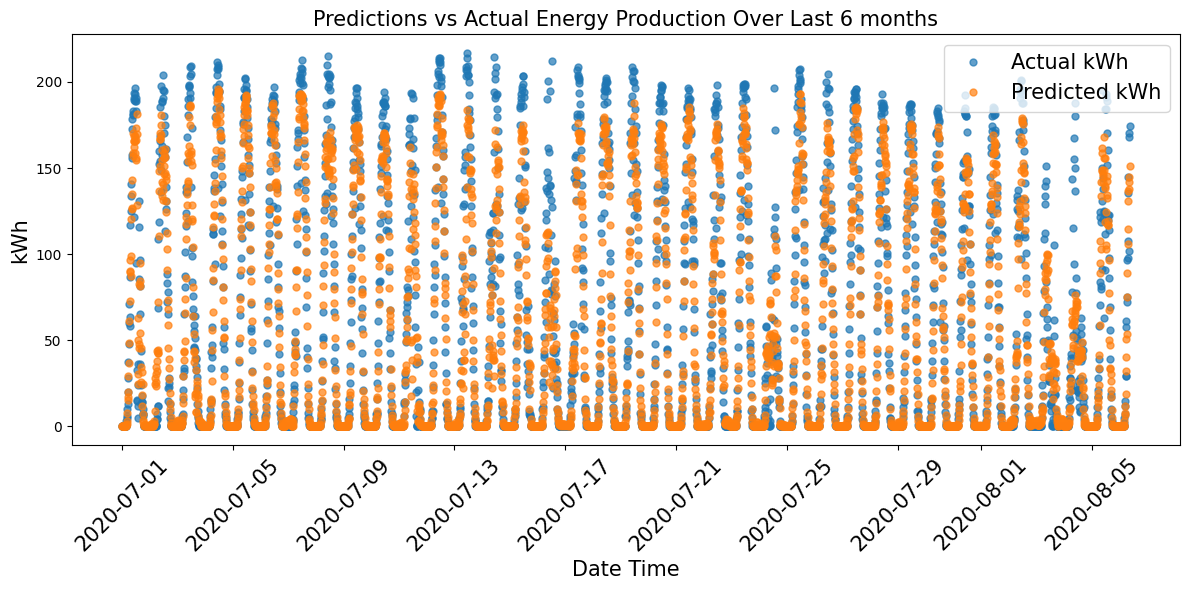

In [ ]:
# Add the predictions (y_pred) to the test set DataFrame for plotting
df_test = X_test_six.copy()
df_test['Actual kWh'] = y_test_six
df_test['Predicted kWh'] = y_pred_six
df_test['timestamp_utc'] = df_merged.loc[df_test.index, 'timestamp_utc']  # Use the original timestamps

# Plot predictions vs actual values over time
plt.figure(figsize=(12, 6))
plt.plot(df_test['timestamp_utc'], df_test['Actual kWh'], 'o', label='Actual kWh', alpha=0.7, markersize=5)
plt.plot(df_test['timestamp_utc'], df_test['Predicted kWh'], 'o', label='Predicted kWh', alpha=0.7, markersize=5)
plt.xlabel('Date Time', fontsize=15)
plt.ylabel('kWh', fontsize=15)
plt.title('Predictions vs Actual Energy Production Over Last 6 months', fontsize=15)
plt.legend(fontsize=15)
plt.xticks(rotation=45, fontsize=15)
plt.tight_layout()
plt.show();

## Outlooks /Conclusion

- We pre-process the data set. In particular we checked for outliers. We also interpolate/merge the data frames to allow a simpler training.
  - Play more with n. of parameters! For instance:
    - n_estimators (number of trees in the forest)
    - criterion{“gini”, “entropy”, “log_loss”}. The function to measure the quality of a split. “gini” for the Gini impurity / “log_loss” / “entropy” both for the Shannon information gain.

### Outlooks
- More carefully check for outliers in the meteo.csv data set too
- I would probably put more effort on the training, for instance try different setups and see if we reach better scores
- I would try to implement some new techniques arising from research papers, e..g, https://www.sciencedirect.com/science/article/pii/S0038092X23001512

- I would try the neural network approach. We might train a LSTM or a Transformer and see if we find a better MSE (or any other equivalent metric)

## Forecasting

basically, if we provide the whether condition for a day in the future, the model can make predictions based on the whether conditions just by calling

```
rf.fit(future_X)
```
it's important to have the same number (and names) of features that we used to train the model though!




In [ ]:
#provide whether conditions
"""
temperature_2m_C =
diffuse_rad_w =
direct_rad_w =
low_cloud_cover_p =
medium_cloud_cover_p =
high_cloud_cover_p =

"""
#predict the future energy production

#rf.predict(future_X)

'\ntemperature_2m_C =\ndiffuse_rad_w =\ndirect_rad_w = \nlow_cloud_cover_p =\nmedium_cloud_cover_p = \nhigh_cloud_cover_p = \n\n'